# Набор данных

**Оценка стоимости  и типа трансмиссии по данным продаж автомобилей на вторичном рынке Молдавии**

# Import библиотек

In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)
pd.set_option("display.precision", 6)
pd.set_option("plotting.backend", "matplotlib")
%matplotlib inline

plt.style.use('default')

# Метод главных компонент

## Класс для вычисления собственных векторов и их собственных значений

In [2]:
class PCA():
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.values = None
        self.mean = None

    def fit(self, X):
        """
        Нахождение собственных значений и собственных векторов
        """

        # оценка среднего для каждого признака
        self.mean = np.mean(X, axis=0)

        # Считаем матрицу ковариации, используя функцию библиотеки Numpy
        # не забываем вычитать среднее
        cov_matrix = np.cov(X - self.mean, rowvar = False)

        # считаем собственные значания и собственные вектора матрицы ковариации
        # для этого тоже есть функция Numpy
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        #Сортируем по возрастанию собственных значений
        idx = eigenvalues.argsort()[::-1]

        # Берём первые n собственных векторов
        self.components = eigenvectors[:, idx][:, :self.n_components]

        # отсортированные собственные значения
        self.values     = eigenvalues[idx]

        return self


    def transform(self, X):
        """
        Преобразование признаков в пространство главных компонент
        """
        #вычитаем среднее
        X = X - self.mean

        #находим проекции признаков на собственные вектора (через скалярное произведение)
        #это и будут главные компоненты
        return np.dot(X, self.components)


    def fit_transform(self, X):
        """
        2 в 1: обучаем и преобразуем
        """
        return self.fit(X).transform(X)


    def inverse_transform(self, X_new):
        """
        Обратное преобразование.
        Главные компоненты скалярно умножаем на собственные вектора
        """

        # не забываем обратно добавить среднее
        return np.dot(X_new, self.components.T) + self.mean

    def show_values(self):
        print( "Eigen_Vectors:")
        print(self.components)
        print("Eigen_Values :")
        print(self.values)


    def score(self, X):
        """
        оцека "качества" восстановления, через коэффициент детерминации
        """

        meanx = np.mean(X)
        SStot = np.sum(np.square(X - meanx))
        SSres = np.sum(np.square(X - self.inverse_transform(self.fit_transform(X))))
        S= 1 - SSres/SStot
        print("Score = ", S)
        return S

    def fast_score(self, X, X_new):
        """
        оцека "качества" восстановления, через коэффициент детерминации
        """

        meanx = np.mean(X)
        SStot = np.sum(np.square(X - meanx))
        SSres = np.sum(np.square(X - self.inverse_transform(X_new)))
        S= 1 - SSres/SStot
        print("Score = ", S)
        return S


    def plot_eigvalues(self, figsize=(15,7)):
        """
        метод для отрисовки собственных значений (объясненной дисперсии)
        """

        plt.figure(figsize=figsize)

        # отдельно мелкими точками визуализируем все собственные значения
        plt.plot(self.values,'.',
                 label='Все собственные значения',
                 linewidth = 3)

        # крупными маркерами - выбранное нами количество главных компонент
        plt.plot(self.values[:self.n_components],'r-o',
                 label='Собственное пространство',
                 markersize = 10, mfc='none',
                 linewidth = 2, alpha = 0.8)

        plt.ylabel('Собственные\n значения', fontsize=25)
        plt.grid();
        plt.legend(fontsize=25);
        plt.xticks(fontsize = 25); plt.yticks(fontsize = 25);
        plt.tight_layout();
        plt.show()


def plot_scatter(x,y, title_text = '', title_x = '', title_y = '', c_value =None, alpha = 0.5):
    if c_value is None:
        c_value='orange'

    plt.scatter(x,y,
                alpha = alpha,
                c = c_value, edgecolor = 'r')
    plt.grid()
    plt.xlabel(title_x, fontsize=25)
    plt.ylabel(title_y, fontsize=25)
    minx=np.min([x.min()*1.2, y.min()*1.2])
    maxx=np.max([x.max()*1.2, y.max()*1.2])
    plt.xlim([minx, maxx])
    plt.ylim([minx, maxx])
    plt.xticks(fontsize = 15); plt.yticks(fontsize = 15);
    plt.title(title_text, fontsize=25)


## Загрузка  данных

Загрузка числовых нормализованных данных

In [3]:
df_num = pd.read_csv('./content/cars_moldova_hw1_df_norm.csv', delimiter = ',')
df_num.tail()

,Distance,Engine_capacity(cm3),Price(euro),Age
32913,0.374999,0.255814,0.078769,0.372549
32914,0.148332,0.186047,0.131296,0.117647
32915,0.000373,0.186047,0.080790,0.235294
32916,0.616666,0.302326,0.070688,0.294118
32917,0.499999,0.186047,0.070688,0.294118


Определяем числовые столбцы

In [4]:
num_columns = df_num.columns
num_columns

Index(['Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'Age'], dtype='object')

Загрузка категориальных кодированных данных

In [5]:
df_ne = pd.read_csv('./content/cars_moldova_hw1_numeric_encoded.csv', delimiter = ',')
df_ne.tail()

,Model,Make,Style,Brand_country,Age_group,Wear,Fuel_type_Diesel,Fuel_type_Electric,Fuel_type_Hybrid,Fuel_type_Metan/Propan,Fuel_type_Petrol,Fuel_type_Plug-in Hybrid,Transmission_Manual
32913,26,10,3,2,3,3,0,0,0,1,0,0,1
32914,23,4,11,2,1,1,1,0,0,0,0,0,1
32915,26,20,4,2,2,0,1,0,0,0,0,0,1
32916,26,12,1,3,2,5,1,0,0,0,0,0,1
32917,19,20,6,2,2,4,1,0,0,0,0,0,1


Определяем категориальные столбцы

In [6]:
cat_columns = df_ne.columns
cat_columns

Index(['Model', 'Make', 'Style', 'Brand_country', 'Age_group', 'Wear',
       'Fuel_type_Diesel', 'Fuel_type_Electric', 'Fuel_type_Hybrid',
       'Fuel_type_Metan/Propan', 'Fuel_type_Petrol',
       'Fuel_type_Plug-in Hybrid', 'Transmission_Manual'],
      dtype='object')

## Применение метода главных компонент
### Применяем разработанный класс PCA

In [7]:
# Признак 'Price(euro)' будем считать целевой переменной. Остальные числовые столбцы
# будут представлять собой исходный набор признаков
X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values
labels = df_ne.Transmission_Manual.values
num_columns=df_num.drop(columns = ['Price(euro)']).columns

# Берем количество компонент, равное количеству признаков в исходном наборе
pca = PCA(n_components = 3)
pca.fit(X)
X_new = pca.transform(X)

In [8]:
pca.score(X)

Score =  1.0


1.0

Коэффициент детерминации R2=1, качество модели отличное

### График собственных значений

eigenvalues [0.0319589  0.01682792 0.01482344]


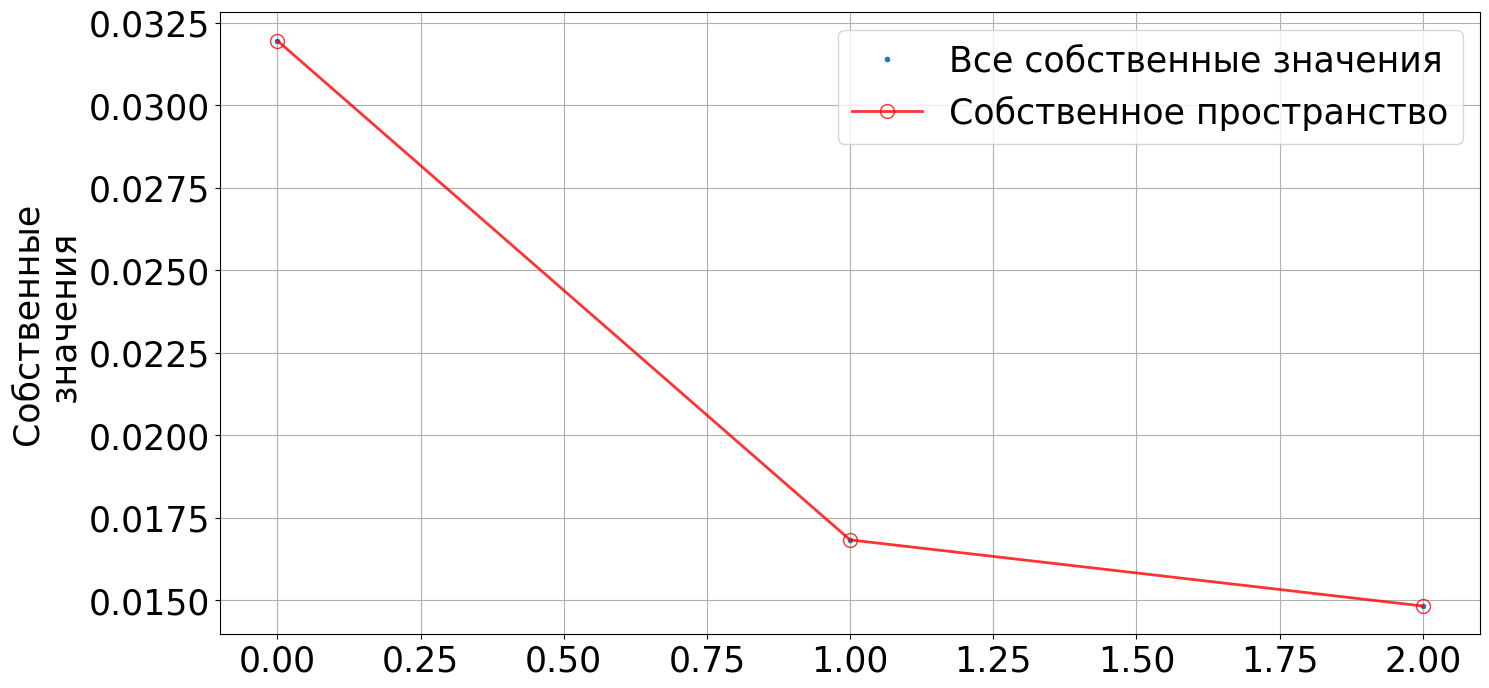

In [9]:
print('eigenvalues',pca.values)
pca.plot_eigvalues()

Веса всех компонентов одного порядка и отличаются не сильно. Поэтому возможности уменьшить количество компонентов в данном случае нет.

### Визуализация пространства главных компонент

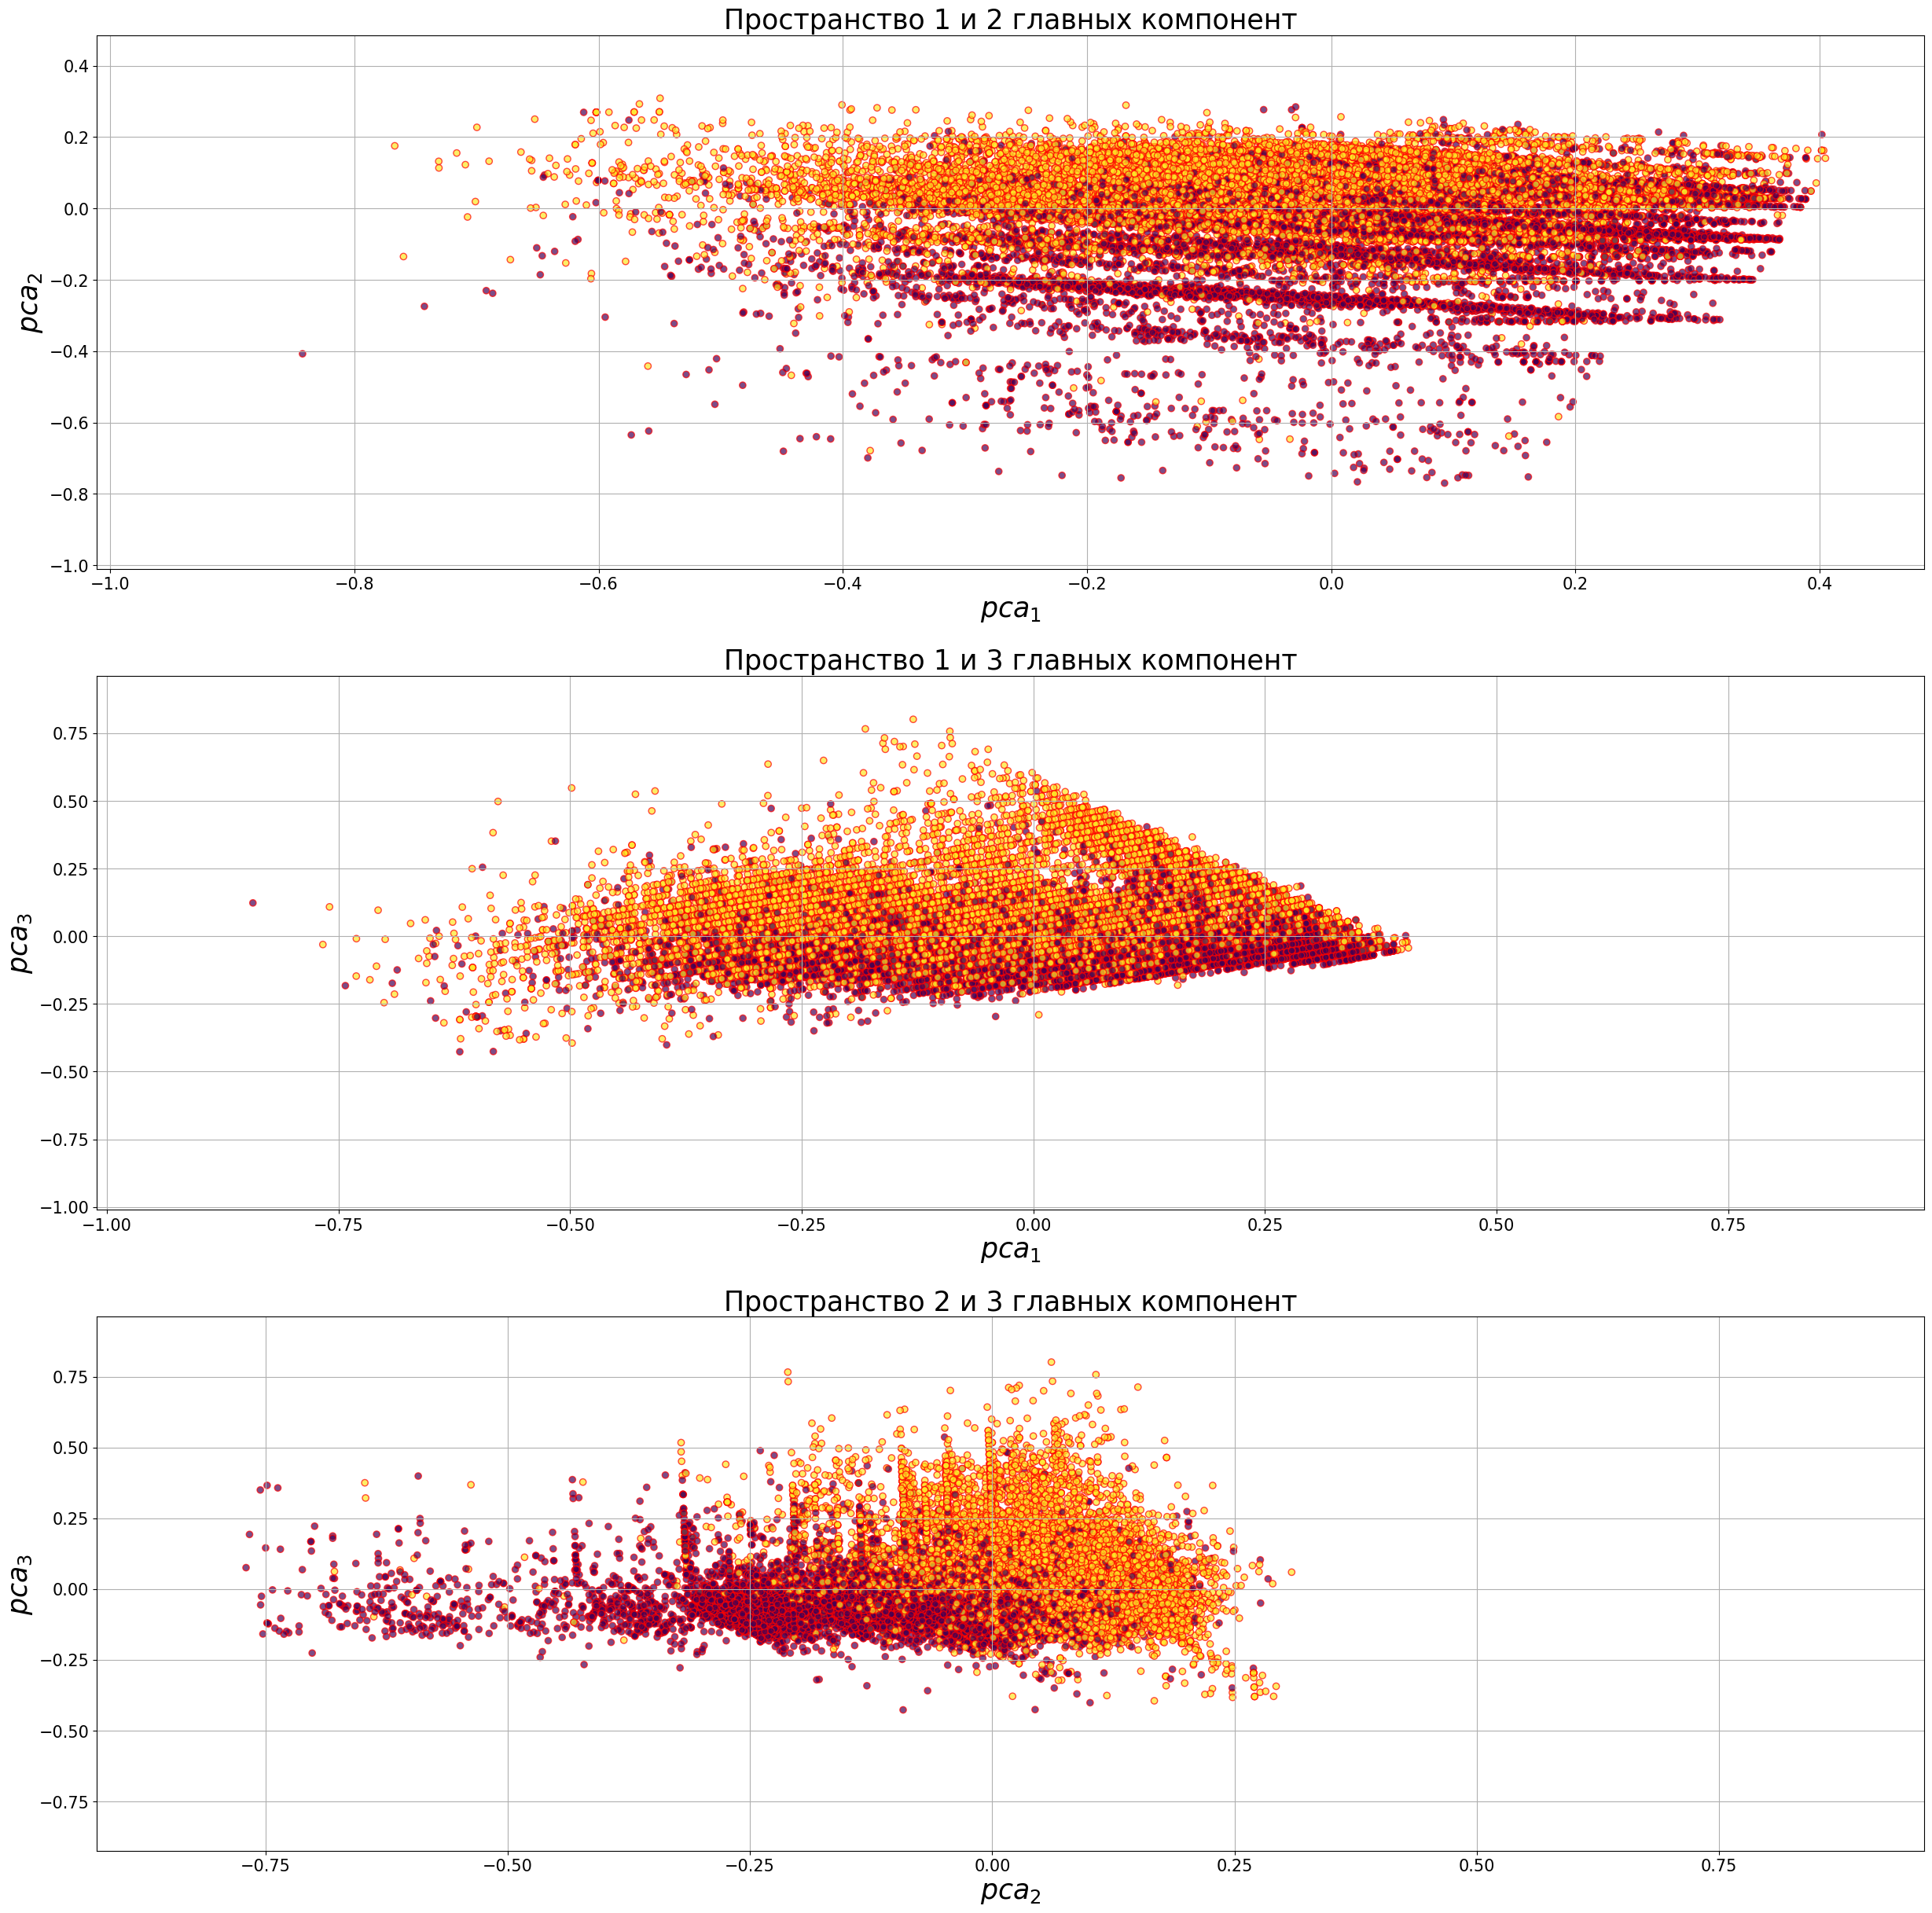

In [10]:
fig=plt.figure(figsize=(30,30))
plt.subplot(311)
plot_scatter( X_new[:,0], X_new[:,1] , "Пространство 1 и 2 главных компонент", r'$pca_1$', r'$pca_2$',  labels, 0.7)
plt.subplot(312)
plot_scatter( X_new[:,0], X_new[:,2] , "Пространство 1 и 3 главных компонент", r'$pca_1$', r'$pca_3$',  labels, 0.7)
plt.subplot(313)
plot_scatter( X_new[:,1], X_new[:,2] , "Пространство 2 и 3 главных компонент", r'$pca_2$', r'$pca_3$',  labels, 0.7)

Графики подтверждают, что очевидного преобладания одной компоненты над другой нет.

### Связь компонет с исходными признаками

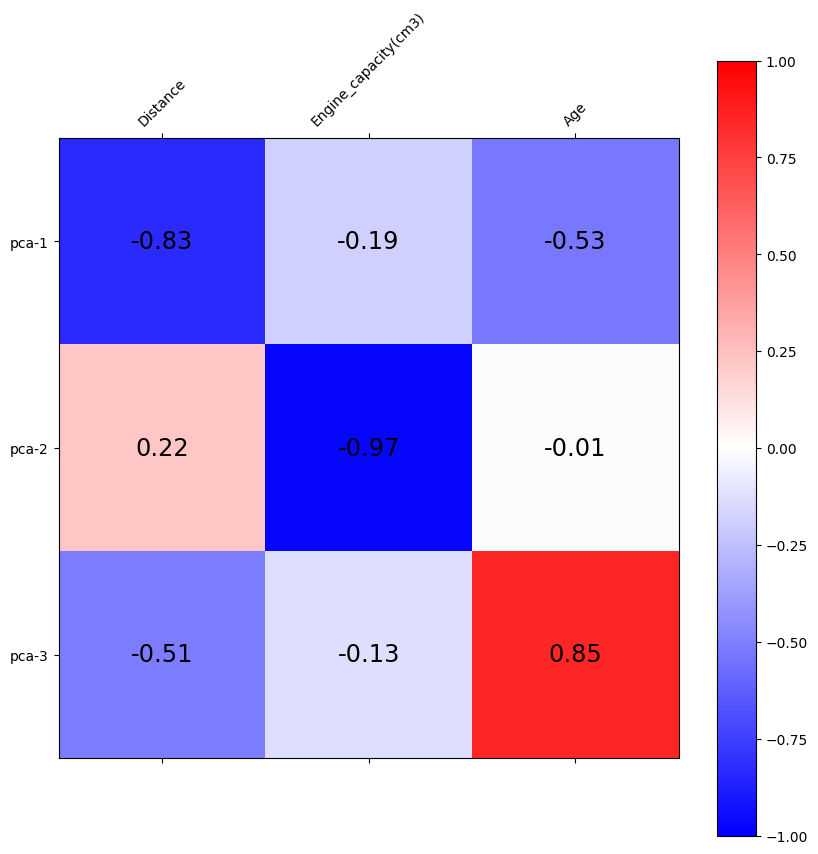

In [11]:
fig=plt.figure(figsize=(10,10))
W = pca.components.T
pca_names = ['pca-'+str(x+1) for x in range(3)]
plt.matshow(W.astype(float),cmap='bwr',vmin=-1,vmax=1, fignum=1)
for (i, j), z in np.ndenumerate(W):
    plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', color = 'k', fontsize = 'xx-large')
plt.xticks(np.arange(0, W.shape[1]), num_columns,rotation = 45)
plt.yticks(np.arange(0, W.shape[0]),pca_names)
plt.colorbar();

Очевидна связь каждой компоненты с одним из трех исходных признаков.

## Восстановление данных

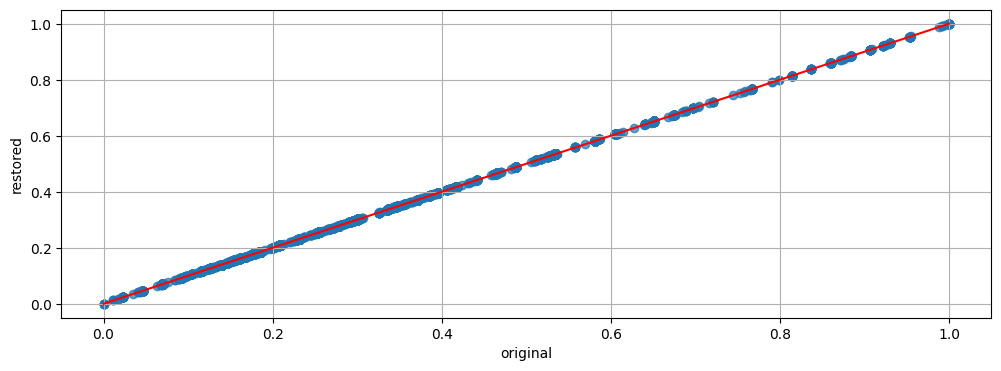

In [12]:
X2 = pca.inverse_transform(X_new)
plt.figure(figsize=(12,4))
plt.scatter(X[:,1],X2[:,1],alpha = 0.7 )
plt.plot([X[:,1].min(),X[:,1].max()],[X[:,1].min(),X[:,1].max()], 'r')
plt.grid()
plt.xlabel('original')
plt.ylabel('restored');

Восстановленные данные практически повторяют исходные данные, отличий нет.

## Линейная Регрессия в пространстве главных компонент

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)
LR = LinearRegression(fit_intercept=True)

LR.fit(X_train, y_train)

B0=LR.intercept_
B=LR.coef_

line='{:.2f}'.format(B0)
sign=['+','-']

#features_names = ['']
for p,(fn,b) in enumerate(zip(pca_names,B)):
  line=line+sign[int(0.5*(np.sign(b)-1))]+'{:.2f}*'.format(np.abs(b))+fn

print('Решение')
print(line)
print('\n')

Решение
0.17+0.36*pca-1-0.52*pca-2-0.55*pca-3




### Визуализация Весов

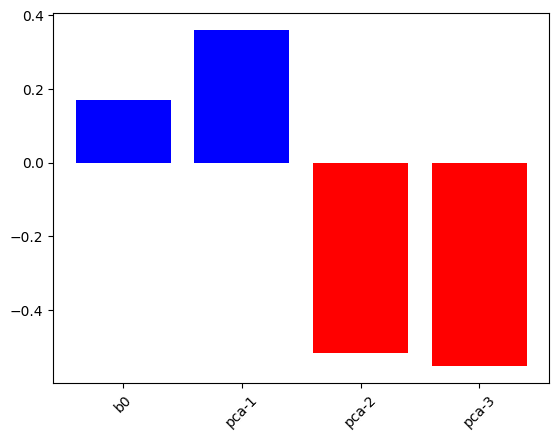

In [14]:
def weights_vis(B, B0, features_names):
    numbers = np.arange(0,len(features_names)+1)
    Bs = np.hstack([B0,B])
    tick_labels = ['B'+str(num) for num in numbers]
    cc=['']*len(numbers)
    for n,val in enumerate(Bs):
        if val<0:
            cc[n]='red'
        elif val>=0:
            cc[n]='blue'

    plt.bar(x = numbers, height = Bs, color = cc)
    plt.xticks(np.arange(0,len(features_names)+1),np.hstack(['b0', features_names]),rotation = 45 )
    plt.show()

weights_vis(B, B0, pca_names)

### Кросс-валидация

In [15]:
scoring = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'Max': 'max_error'}

scores = cross_validate(LR, X_train, y_train,
                      scoring=scoring, cv=ShuffleSplit(n_splits=5, random_state=42) )

print('Результаты Кросс-валидации')
DF_cv_linreg = pd.DataFrame(scores)
print(DF_cv_linreg)
print('\n')
print(DF_cv_linreg.mean()[2:])
print('\n')

Результаты Кросс-валидации
   fit_time  score_time   test_R2  test_-MSE  test_-MAE  test_Max
0  0.002088    0.000443  0.517678  -0.012136  -0.071057 -0.925303
1  0.001663    0.000338  0.523801  -0.012371  -0.072337 -0.860297
2  0.001491    0.000321  0.560382  -0.011375  -0.070150 -0.775329
3  0.001425    0.000314  0.539343  -0.012186  -0.072573 -0.878774
4  0.001412    0.000306  0.543539  -0.011782  -0.070437 -0.878967


test_R2      0.536949
test_-MSE   -0.011970
test_-MAE   -0.071311
test_Max    -0.863734
dtype: float64




### Расчет метрик

In [16]:
LR.fit(X_train, y_train)
y_predict=LR.predict(X_test)

print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test,y_predict))
print('RMSE: %.1f' % mse(y_test,y_predict,squared=False))
print('R2 : %.4f' %  r2_score(y_test,y_predict))
print('Абсолютный размах значений: %.1f' % (y.max()-y.min()))

Ошибка на тестовых данных
MSE: 0.0
RMSE: 0.1
R2 : 0.5425
Абсолютный размах значений: 1.0


Результаты применения линейной регрессии в пространстве главных компонент в данном случае не принесло никакой пользы, полученные главные компоненты практически повторяют исходные признаки, и метрики качества в обоих случаях близки (R2= 0.5425  в пространстве главных компонент и 0.5266 в пространстве исходных признаков.

## PCA на категориальных данных

Проверим как работает PCA на категориальных данных

In [17]:
# Удаляем признаки,влияние которых слишком мало
transformed_fields = ['Model','Make', 'Style', 'Brand_country', 'Age_group', 'Wear', 'Transmission_Manual', 'Fuel_type_Plug-in Hybrid', 'Fuel_type_Electric']
df_ne_cat = df_ne.drop(columns = transformed_fields)

df_num_cat = df_num.drop(columns = ['Price(euro)'])
df_num_cat= pd.concat([df_num_cat,df_ne_cat], axis = 1)
num_columns_cat = df_num_cat.columns
df_num_cat.tail()

,Distance,Engine_capacity(cm3),Age,Fuel_type_Diesel,Fuel_type_Hybrid,Fuel_type_Metan/Propan,Fuel_type_Petrol
32913,0.374999,0.255814,0.372549,0,0,1,0
32914,0.148332,0.186047,0.117647,1,0,0,0
32915,0.000373,0.186047,0.235294,1,0,0,0
32916,0.616666,0.302326,0.294118,1,0,0,0
32917,0.499999,0.186047,0.294118,1,0,0,0


In [18]:
pca_cat = PCA(n_components=5)
X_cat=df_num_cat.values

X_new_cat = pca_cat.fit_transform(X_cat)
X_new_cat.shape

(32918, 5)

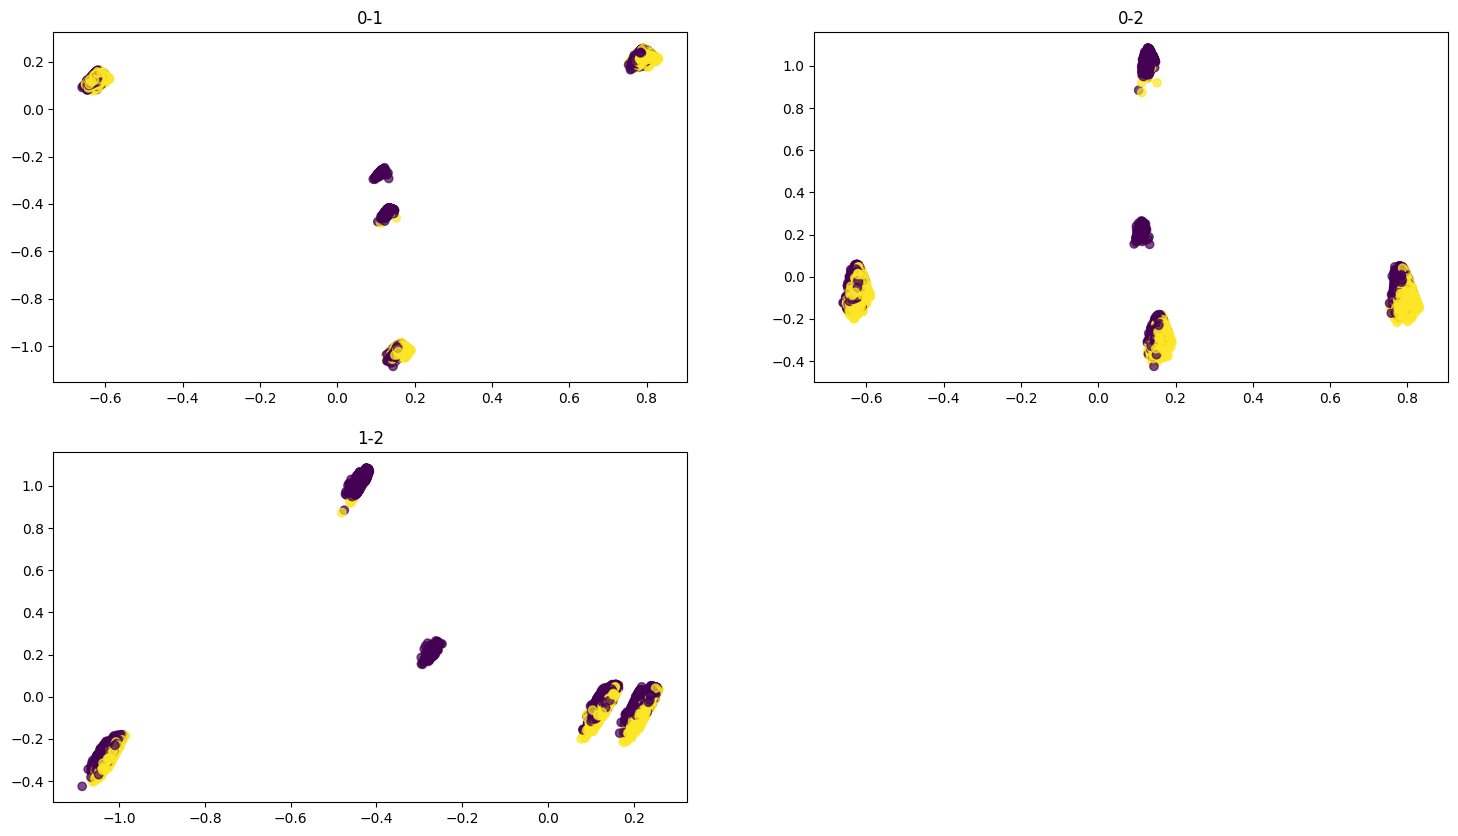

In [19]:
plt.figure(figsize=(18,10))
plt.subplot(221); plt.scatter(X_new_cat[:,0],X_new_cat[:,1], c =labels, alpha = 0.7); plt.title("0-1")
plt.subplot(222); plt.scatter(X_new_cat[:,0],X_new_cat[:,2], c =labels, alpha = 0.7); plt.title("0-2")
plt.subplot(223); plt.scatter(X_new_cat[:,1],X_new_cat[:,2], c =labels, alpha = 0.7); plt.title("1-2")
plt.show();

### График собственных значений

Score =  0.9800072087997878


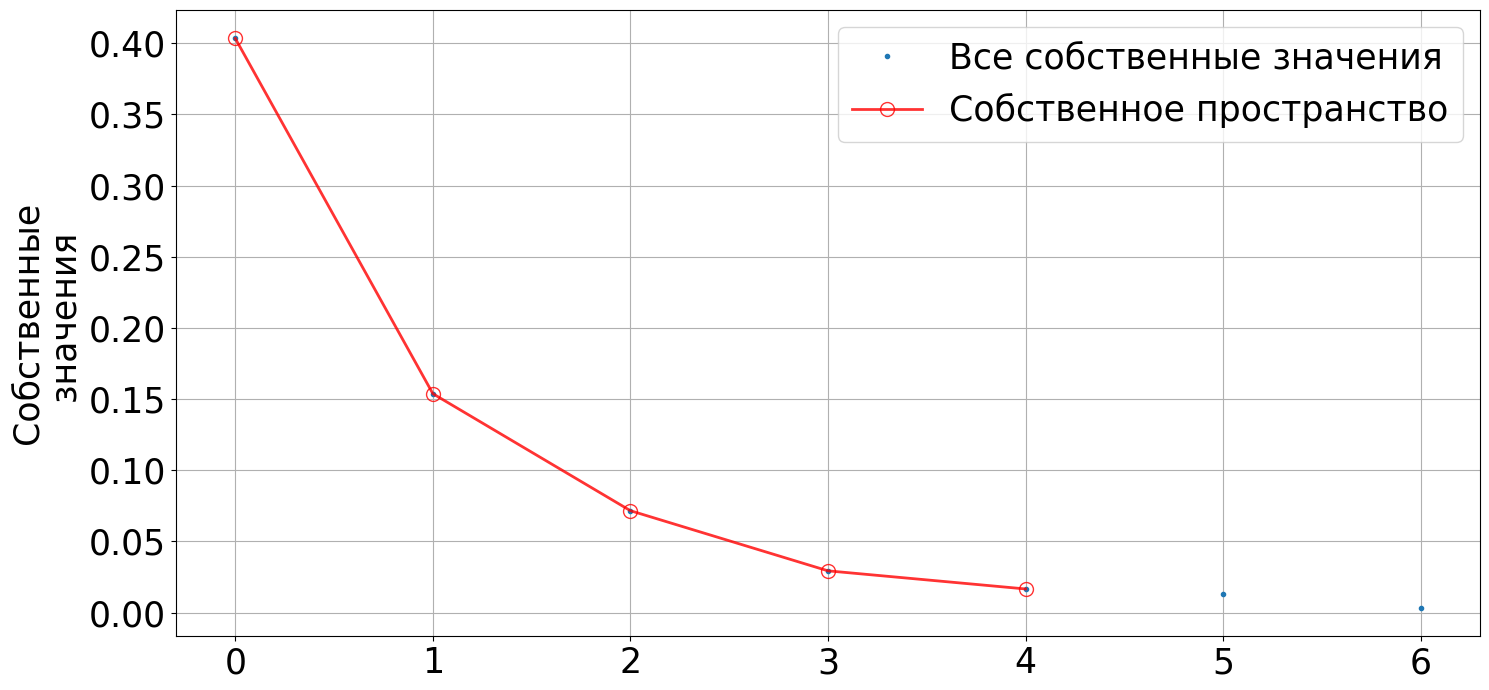

In [20]:
pca_cat.score(X_cat)
pca_cat.plot_eigvalues()

In [21]:
print('eigenvalues',np.cumsum(pca_cat.values))

eigenvalues [0.40331132 0.55706186 0.62861583 0.65792965 0.6745167  0.68733592
 0.6906799 ]


Веса всех компонентов от 5-го и далее слишком малы, и ими можно пренебречь.

### Связь компонент с исходными признаками

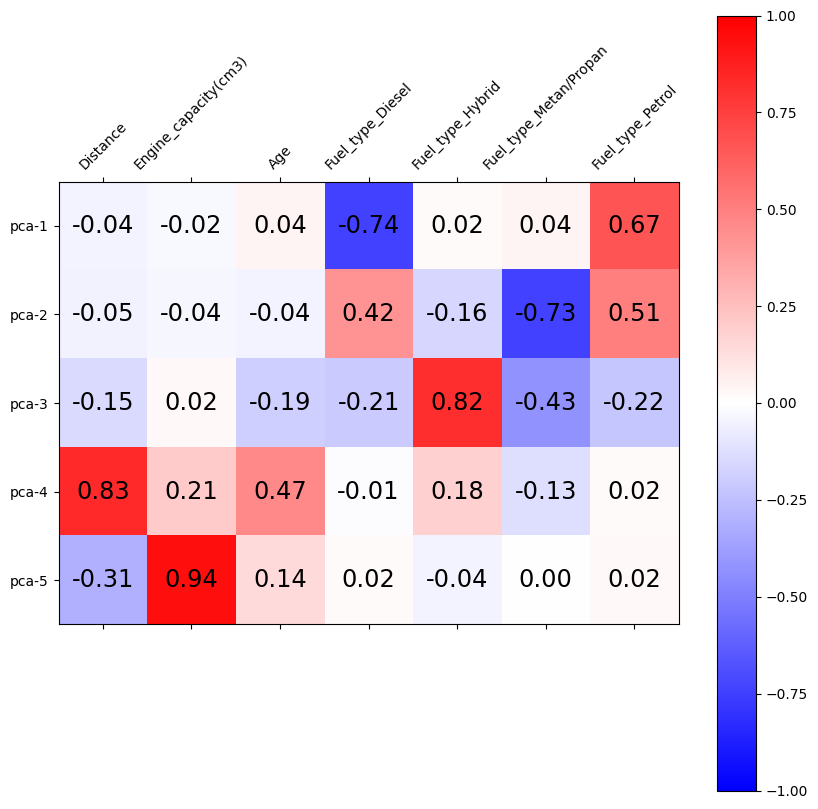

In [22]:
ig=plt.figure(figsize=(10,10))
W = pca_cat.components.T
pca_names = ['pca-'+str(x+1) for x in range(5)]
plt.matshow(W.astype(float),cmap='bwr',vmin=-1,vmax=1, fignum=1)
for (i, j), z in np.ndenumerate(W):
    plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', color = 'k', fontsize = 'xx-large')
plt.xticks(np.arange(0, W.shape[1]), num_columns_cat,rotation = 45)
plt.yticks(np.arange(0, W.shape[0]),pca_names)
plt.colorbar();

Очевидна связь каждой компоненты с одним или несколькими исходными признаками

### Линейная Регрессия в пространстве главных компонент

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_new_cat, y, test_size=0.3, random_state=42)
LR = LinearRegression(fit_intercept=True)

LR.fit(X_train, y_train)

B0=LR.intercept_
B=LR.coef_

line='{:.2f}'.format(B0)
sign=['+','-']

#features_names = ['']
for p,(fn,b) in enumerate(zip(pca_names,B)):
  line=line+sign[int(0.5*(np.sign(b)-1))]+'{:.2f}*'.format(np.abs(b))+fn

print('Решение')
print(line)
print('\n')

Решение
0.17-0.03*pca-1+0.03*pca-2+0.17*pca-3-0.30*pca-4+0.42*pca-5




### Визуализация Весов

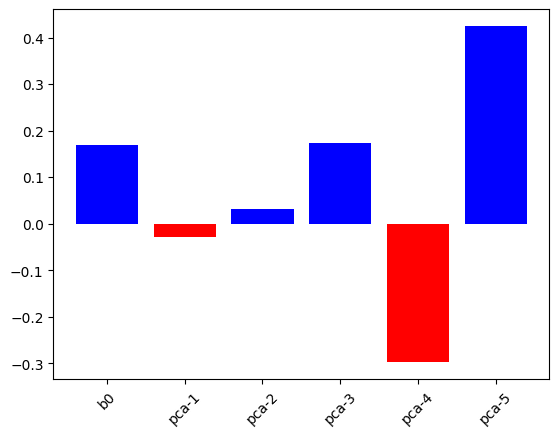

In [24]:
weights_vis(B, B0, pca_names)

In [25]:
LR.fit(X_train, y_train)
y_predict=LR.predict(X_test)

print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test,y_predict))
print('RMSE: %.1f' % mse(y_test,y_predict,squared=False))
print('R2 : %.4f' %  r2_score(y_test,y_predict))
print('Абсолютный размах значений: %.1f' % (y.max()-y.min()))

Ошибка на тестовых данных
MSE: 0.0
RMSE: 0.1
R2 : 0.3300
Абсолютный размах значений: 1.0


Вывод: качество модели при применении категориальных признаков ухудшилось.

# Кластеризация k-средних

## Класс для выполнения кластеризации

In [26]:
class KMeans():
    def __init__(self,n_clusters = 2, centroids = None,
                 max_iter=10, tol=0.01,
                 metric = 'euclidean', p = 2,
                 random_state = None):
        self.n_clusters = n_clusters
        self.centroids  = centroids
        self.max_iter   = max_iter
        self.tol        = tol
        self.iters      = None
        self.inertia = None
        self.metric = metric
        self.p  = p
        self.random_state  = random_state


    def distance(self,X1, X2):
        """
        оценка расстояния
        """

        if self.metric == 'euclidean':
            dist = np.sqrt(np.sum(np.square(X1 - X2).T,axis=0))
        if self.metric == 'cityblock':
            dist = np.sum(np.abs(X1 - X2).T,axis=0)
        if self.metric == 'Chebyshev':
            dist = np.max(np.abs(X1 - X2).T,axis=0)
        if self.metric == 'Minkowski':
            dist = np.power(np.sum(np.power(np.abs(X1 - X2),self.p).T,axis=0),1/self.p)
        return dist


    def init_centroids(self, X):
        """
        инициализация первых центров кластеров
        """

        if self.random_state: rng = np.random.seed(self.random_state)
        c_idxs = np.random.randint(0, X.shape[0], size = self.n_clusters)
        return X[c_idxs,:]


    def predict(self, X):
        """
        оценка пренадлежности точек к кластеру по расстоянию
        """

        distances = np.zeros((X.shape[0], self.n_clusters))

        for i,centr in enumerate(self.centroids):
            distances[:,i] = self.distance(centr,X)
        self.inertia = np.sum(np.power(np.min(distances,axis = 1),2))
        return np.argmin(distances,axis = 1)


    def transform(self,X):
        # получение предсказаний
        return self.predict(X)


    def delta_centroids(self,old_centroids):
        """
        оценка относительного изменения центров кластеров.
        относительное расстояние между старыми и новыми центроидами
        """

        return (
                self.distance(self.centroids,old_centroids)/
                self.distance(old_centroids, np.mean(old_centroids))
               ).mean()


    def fit(self, X):
        """
        Итерационная кластеризация.
        обучение - несколько итераций алгоритма к-Средних
        """

        if self.centroids is None: # если центры кластеров не заданы - задаем
            self.centroids = self.init_centroids(X)

        d_centrs = np.inf

        for i in range(self.max_iter):

            old_centroids = np.copy(self.centroids)

            cluster_label = self.predict(X)

            for k in range(self.n_clusters):

                c_idxs = np.flatnonzero(cluster_label==k)

                self.centroids[k] = X[c_idxs].mean(axis = 0)

            d_centrs = self.delta_centroids(old_centroids)

            self.iters = i
            if d_centrs<=self.tol:
                break
        return self


    def fit_transform(self, X):
        """
         и обучаем и сразу выдаем метки кластеров
        """

        return self.fit(X).predict(X)

## Данные

In [27]:
X = df_num.values
X.shape

(32918, 4)

## Выполнение кластеризации в разных двумерных проекциях

**Кластеризация 0-го и 3-го признаков ('Distance' и 'Age')**

Мы остановились на итерации: 27


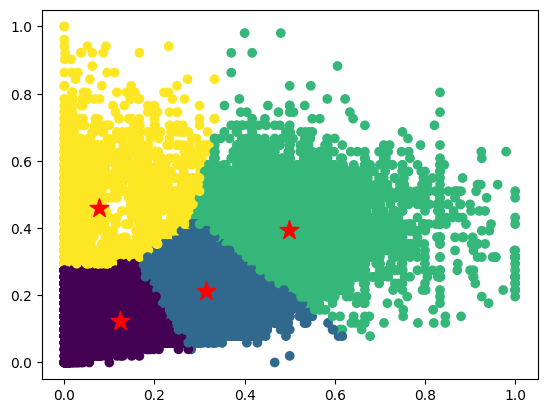

In [28]:
kmeans   = KMeans(n_clusters=4, max_iter=1000, tol=0.0001)
c_labels = kmeans.fit_transform(X[:,[0,3]])

print('Мы остановились на итерации:',kmeans.iters)

plt.scatter(X[:, 0], X[:, 3], c = c_labels)

plt.scatter(kmeans.centroids[:,0], kmeans.centroids[:,1],marker='*', s=200, c='red')

In [29]:
#  Связь кластеров с категориальными признаками
pd.crosstab(labels,c_labels, rownames=['Метки'], colnames = ['Предсказания'])

Предсказания,0,1,2,3
Метки,,,,
0,5539,6669,2065,471
1,2375,8314,5167,2318


По этой таблице видно, что 0-й, 1-й и 3-й кластеры наиболее связаны с 1-ой меткой, а 2-й  - с 0-й меткой.

**Кластеризация 0-го и 1-го признаков ('Distance' и  'Engine_capacity(cm3)')**

Мы остановились на итерации: 21


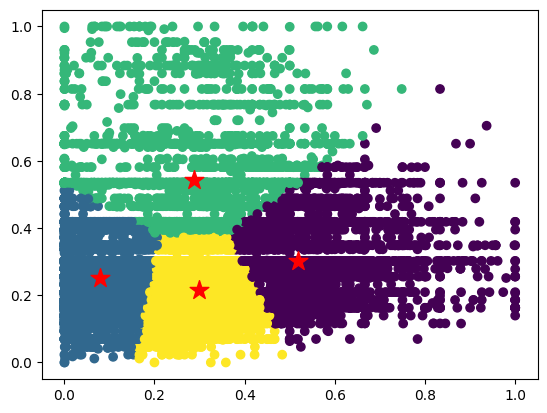

In [30]:
kmeans   = KMeans(n_clusters=4, max_iter=1000, tol=0.0001)
c_labels = kmeans.fit_transform(X[:,[0,1]])

print('Мы остановились на итерации:',kmeans.iters)

plt.scatter(X[:, 0], X[:, 1], c = c_labels)

plt.scatter(kmeans.centroids[:,0], kmeans.centroids[:,1],marker='*', s=200, c='red')

In [31]:
#  Связь кластеров с категориальными признаками
pd.crosstab(labels,c_labels, rownames=['Метки'], colnames = ['Предсказания'])

Предсказания,0,1,2,3
Метки,,,,
0,1857,4014,3290,5583
1,4276,3558,399,9941


По этой таблице видно, что 1-й и 2-й кластеры наиболее связаны с 1-ой меткой, а 0-й и 3-й - с 0-й меткой.

**Кластеризация 0-го и 2-го признаков ('Distance' и 'Price')**

Мы остановились на итерации: 26


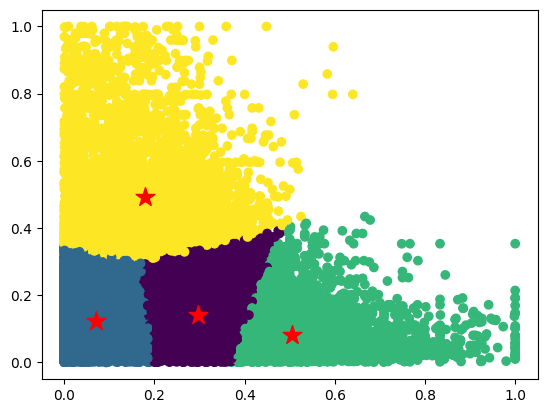

In [32]:
kmeans   = KMeans(n_clusters=4, max_iter=1000, tol=0.0001)
c_labels = kmeans.fit_transform(X[:,[0,2]])

print('Мы остановились на итерации:',kmeans.iters)

plt.scatter(X[:, 0], X[:, 2], c = c_labels)

plt.scatter(kmeans.centroids[:,0], kmeans.centroids[:,1],marker='*', s=200, c='red')

In [33]:
#  Связь кластеров с категориальными признаками
pd.crosstab(labels,c_labels, rownames=['Метки'], colnames = ['Предсказания'])

Предсказания,0,1,2,3
Метки,,,,
0,6276,2284,2160,4024
1,9202,3569,5227,176


По этой таблице видно, что 0-й, 1-й и 3-й кластеры наиболее связаны с 1-ой меткой, а 2-й - с 0-й меткой.

**Кластеризация 1-го и 2-го признаков ( 'Engine_capacity(cm3)' и 'Price')**

Мы остановились на итерации: 20


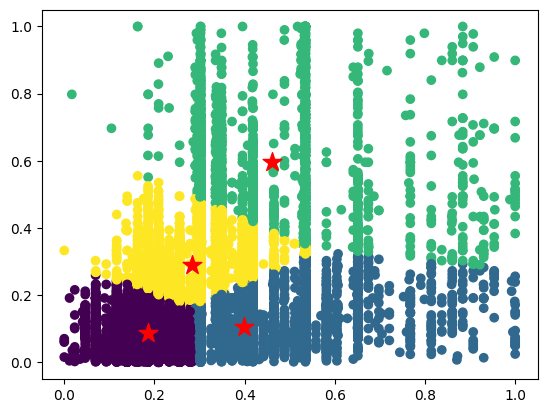

In [34]:
kmeans   = KMeans(n_clusters=4, max_iter=1000, tol=0.0001)
c_labels = kmeans.fit_transform(X[:,[1,2]])

print('Мы остановились на итерации:',kmeans.iters)

plt.scatter(X[:, 1], X[:, 2], c = c_labels)

plt.scatter(kmeans.centroids[:,0], kmeans.centroids[:,1],marker='*', s=200, c='red')

In [35]:
#  Связь кластеров с категориальными признаками
pd.crosstab(labels,c_labels, rownames=['Метки'], colnames = ['Предсказания'])

Предсказания,0,1,2,3
Метки,,,,
0,2944,3892,2152,5756
1,12692,4114,37,1331


По этой таблице видно, что 0-й и 2-й кластеры наиболее связаны с 1-ой меткой, а 1-й и 3-й - с 0-й меткой.

**Кластеризация 2-го и 3-го признаков ('Price' и 'Age')**

Мы остановились на итерации: 41


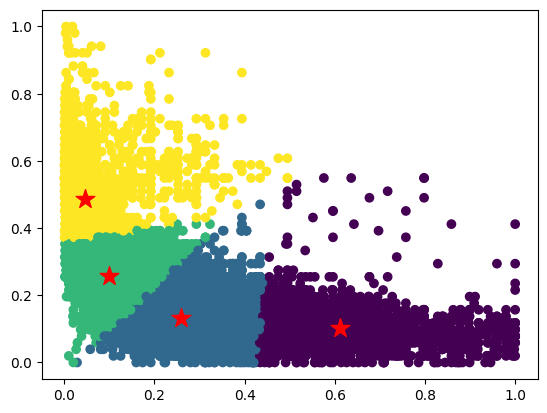

In [36]:
kmeans   = KMeans(n_clusters=4, max_iter=1000, tol=0.0001)
c_labels = kmeans.fit_transform(X[:,[2,3]])

print('Мы остановились на итерации:',kmeans.iters)

plt.scatter(X[:, 2], X[:, 3], c = c_labels)

plt.scatter(kmeans.centroids[:,0], kmeans.centroids[:,1],marker='*', s=200, c='red')

In [37]:
#  Связь кластеров с категориальными признаками
pd.crosstab(labels,c_labels, rownames=['Метки'], colnames = ['Предсказания'])

Предсказания,0,1,2,3
Метки,,,,
0,2090,7030,4695,929
1,43,2602,10706,4823


По этой таблице видно, что 0-й и,2-й кластеры наиболее связаны с 1-ой меткой, а 1-й и 3-й - с 0-й меткой.
